In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import seaborn as sns

import src.metrics as metrics
import src.kernels as kernels
import src.bootstrap as boot

In [2]:
np.random.seed(2024)

In [3]:
dim = 1
n = 1000

x_sample = np.random.multivariate_normal(np.zeros((dim,)), np.eye(dim), n)

y_sample = np.random.multivariate_normal(np.zeros((dim,)), np.eye(dim), n)

In [190]:
kernel = kernels.RBF(sigma_sq=2.)
mmd = metrics.MMD(kernel)
mmd(x_sample, y_sample)

0.001984325400114839

In [177]:
bootstrap = boot.WildBootstrap(mmd, ndraws=5)
pval = bootstrap.pval(x_sample, y_sample)

boot_stats [0.15740258 0.20144756 0.07016762 0.14974205 0.07403273]


In [178]:
pval

0.5

In [184]:
bootstrap = boot.WildBootstrap(mmd, ndraws=5)
pval = bootstrap.pval(x_sample, y_sample)

boot_stats [0.15740258 0.20144756 0.07016762 0.14974205 0.07403273]


In [185]:
pval

0.5

In [186]:
def mmd_experiment_single(kernel_class, Xs, Ys, eps, nboot=500, alpha=0.05):
    res = {
        "deviation": {"val": [], "threshold": [], "rej": []},
        "boot": {"val": [], "threshold": [], "pval": [], "rej": []},
        "robust": {"val": [], "threshold": [], "rej": []},
        "relaxed": {"val": [], "threshold": [], "rej": []},
    }

    for X, Y in tqdm(zip(Xs, Ys), total=Xs.shape[0]):
        kernel = kernel_class(sigma_sq=2.)
        mmd = metrics.MMD(kernel)
        val = mmd(X, Y)
        threshold = mmd.test_threshold(X.shape[0])
        
        # 1. deviation bound
        rej = float(threshold < val)

        # 2. bootstrap
        bootstrap = boot.WildBootstrap(mmd, ndraws=nboot)
        pval = bootstrap.pval(X, Y)

        # 3. robust bootstrap
        robust_bstrp = boot.RobustMMDTest(mmd, eps0=eps, ndraws=nboot)
        robust_rej = robust_bstrp.test(0.05, X, Y)
        
        # 4. robust deviation bound
        # thresh_dev_robust = mmd.test_threshold(X.shape[0], method="deviation_robust", eps=eps)
        # rej_dev_robust = float(thresh_dev_robust < val)
        thresh_relaxed = (alpha - eps) / (1 - eps)
        rej_relaxed = float(pval < thresh_relaxed)
        
        # save results
        res["deviation"]["val"].append(val)
        res["deviation"]["threshold"].append(threshold)
        res["deviation"]["rej"].append(rej)
        
        res["boot"]["val"].append(val)
        res["boot"]["threshold"].append(threshold)
        res["boot"]["pval"].append(pval)
        res["boot"]["rej"].append(float(pval < alpha))

        res["robust"]["val"].append(val)
        res["robust"]["threshold"].append(threshold)
        res["robust"]["rej"].append(robust_rej)
        
        res["relaxed"]["val"].append(val)
        res["relaxed"]["threshold"].append(thresh_relaxed)
        res["relaxed"]["rej"].append(rej_relaxed)

    return res

def mmd_experiment(kernel_class, Xs, Ys, eps0, keys, nboot=500):
    """
    Xs: [array(nrep, n, d), ...]
    Ys: [array(nrep, n, d), ...]
    """
    res = {}
    for Xs_i, Ys_i, kk in zip(Xs, Ys, keys):
        res[kk] = mmd_experiment_single(kernel_class, Xs_i, Ys_i, eps0)

    return res
    

In [187]:
np.random.seed(2024)

In [188]:
nrep = 20
n = 1000
mean1 = np.zeros((dim,))
mean2 = np.zeros((dim,)) + 0.8

### Gaussian loc
# Xs = np.random.multivariate_normal(mean1, np.eye(dim), (nrep, n))

# Ys = np.random.multivariate_normal(mean2, np.eye(dim), (nrep, n))

### Gaussian contam
Xs = np.random.multivariate_normal(mean1, np.eye(dim), (nrep, n))

eps = 0.025 # 0.28
outlier = 10
mask = np.random.binomial(1, eps, (nrep, n))
clean_samples = np.random.multivariate_normal(mean1, np.eye(dim), (nrep, n))
Ys = np.where(np.expand_dims(mask, -1), np.ones_like(clean_samples) * outlier, clean_samples)

### mixture of Gaussian and t
# Xs = np.random.multivariate_normal(mean1, np.eye(dim), (nrep, n))

# eps = 0.025
# mask = np.random.binomial(1, eps, (nrep, n))
# norm_rvs = np.random.multivariate_normal(mean1, np.eye(dim), (nrep, n))
# t_rvs = 10. + np.expand_dims(np.random.standard_t(df=2, size=(nrep, n)), -1) 
# Ys = np.where(np.expand_dims(mask, -1), t_rvs, norm_rvs)
###

kernel_class = kernels.RBF

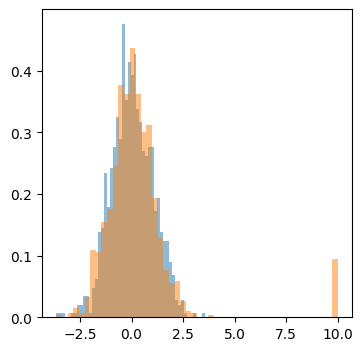

In [189]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
_ = ax.hist(Xs[0, :, 0], bins=50, label="X", alpha=0.5, density=True)
_ = ax.hist(Ys[0, :, 0], bins=50, label="Y", alpha=0.5, density=True)

In [190]:
res = mmd_experiment_single(kernel_class, Xs, Ys, eps=eps, nboot=500)

  0%|          | 0/20 [00:00<?, ?it/s]

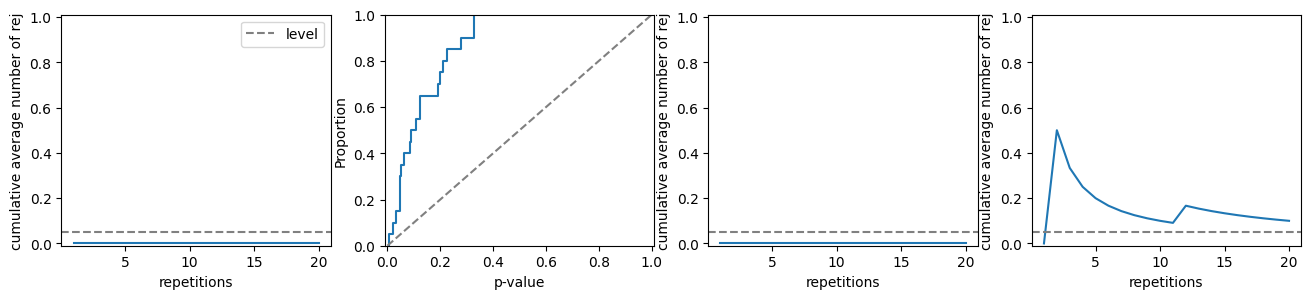

In [195]:
figs, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 3))

ax = axes[0]
ma = np.cumsum(res["deviation"]["rej"]) / (np.arange(nrep) + 1.)
ax.plot(np.arange(nrep) + 1., ma)
ax.axhline(0.05, color="grey", linestyle="--", label="level")
ax.set_ylim(-0.01, 1.01)
ax.set_xlabel("repetitions")
ax.set_ylabel("cumulative average number of rej")
_ = ax.legend()

ax = axes[1]
sns.ecdfplot(ax=ax, x=res["boot"]["pval"])
_ = ax.axline((0., 0.), slope=1., color="grey", linestyle="--")
ax.set_xlim(-0.01, 1.01)
ax.set_ylim(0., 1.)
_ = ax.set_xlabel("p-value")

ax = axes[2]
ma = np.cumsum(res["robust"]["rej"]) / (np.arange(nrep) + 1.)
ax.plot(np.arange(nrep) + 1., ma)
ax.axhline(0.05, color="grey", linestyle="--", label="level")
ax.set_ylim(-0.01, 1.01)
ax.set_xlabel("repetitions")
ax.set_ylabel("cumulative average number of rej")

if len(res["relaxed"]["rej"]) > 0:
    ax = axes[3]
    ma = np.cumsum(res["relaxed"]["rej"]) / (np.arange(nrep) + 1.)
    ax.plot(np.arange(nrep) + 1., ma)
    ax.axhline(0.05, color="grey", linestyle="--", label="level")
    ax.set_ylim(-0.01, 1.01)
    ax.set_xlabel("repetitions")
    ax.set_ylabel("cumulative average number of rej")


#### Multiple experiments

In [196]:
np.random.seed(2024)

In [197]:
nrep = 100
mean1 = np.zeros((dim,))
# mean2 = np.zeros((dim,)) + 0.8.

eps = 0.025
outlier_ls = [0.1, 1., 10., 100., 1e3, 1e4]

Xs_ls = []
Ys_ls = []

for outlier in outlier_ls:
    ### Gaussian contam
    Xs = np.random.multivariate_normal(mean1, np.eye(dim), (nrep, n))
    
    mask = np.random.binomial(1, eps, (nrep, n))
    clean_samples = np.random.multivariate_normal(mean1, np.eye(dim), (nrep, n))
    Ys = np.where(np.expand_dims(mask, -1), np.ones_like(clean_samples) * outlier, clean_samples)
    ###

    Xs_ls.append(Xs)
    Ys_ls.append(Ys)

kernel_class = kernels.RBF

keys = outlier_ls

In [ ]:
res = mmd_experiment(kernel_class, Xs_ls, Ys_ls, eps0=eps, keys=keys, nboot=500)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

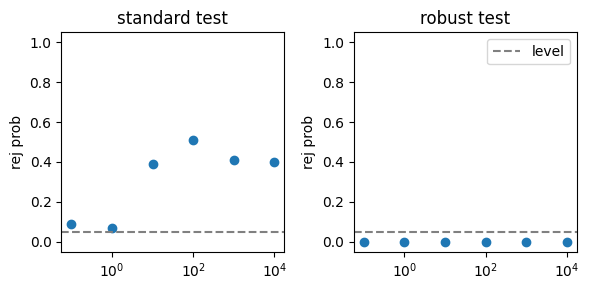

In [73]:
figs, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 3))

ax = axes[0]
rej_prob = [np.mean(res[kk]["boot"]["rej"]) for kk in keys]
ax.scatter(keys, rej_prob)
ax.axhline(0.05, color="grey", linestyle="--", label="level")
ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel("")
ax.set_ylabel("rej prob")
ax.set_title("standard test")

ax = axes[1]
rej_prob = [np.mean(res[kk]["robust"]["rej"]) for kk in keys]
ax.scatter(keys, rej_prob)
ax.axhline(0.05, color="grey", linestyle="--", label="level")
ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel("")
ax.set_ylabel("rej prob")
ax.set_title("robust test")

ax = axes[1]
rej_prob = [np.mean(res[kk]["relaxed"]["rej"]) for kk in keys]
ax.scatter(keys, rej_prob)
ax.axhline(0.05, color="grey", linestyle="--", label="level")
ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel("")
ax.set_ylabel("rej prob")
ax.set_title("robust test")

_ = axes[0].legend()
_ = plt.tight_layout()